<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})

In [2]:
def read_data(url, dataset_name, sep=","):
    r = requests.get(url)
    soup = BeautifulSoup.BeautifulSoup(r.text)
    ressources_list = soup.find("div", "resources-list")
    url = None
    for article in ressources_list.find_all("article"):
      if dataset_name in article.div.h4.text:
        url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
        break
    if url == None:
      raise("data not found")
    return pd.read_csv(url, sep=sep)
    
df = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-nouveaux-covid19",
    ";"
)

df.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
5348,976,2020-05-06,7,1,1,6
5349,976,2020-05-07,11,1,0,4
5350,976,2020-05-08,4,2,0,3
5351,976,2020-05-09,5,0,0,4
5352,976,2020-05-10,9,2,0,1


In [0]:
def display_df(df, title, logscale=False):
    """
    df a pour index les jours et les cols ["incid_hosp", "incid_rea"]
    """
    daily = df[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if daily["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
        disp = ["incid_hosp", "incid_rea", "hosp_desaiso"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "réanimation"]
        disp = ["incid_hosp", "incid_rea", "hosp_lisse"]

    plt.figure(figsize=(15,8))
    if logscale:
        plt.yscale('log')
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(title, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données : \n")
    print(dept[disp].apply(np.rint).tail())

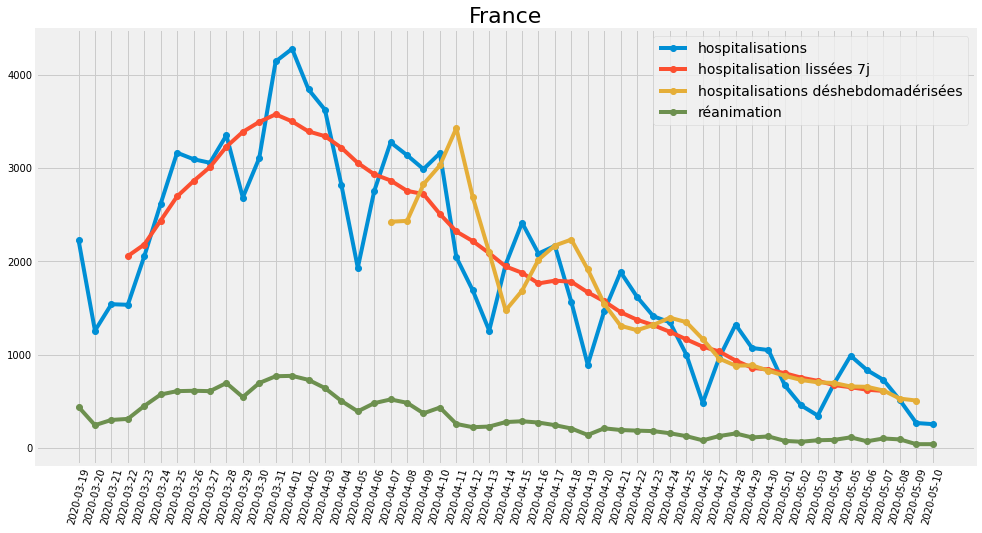


dernières données : 

            incid_hosp  incid_rea  hosp_desaiso
2020-05-06       833.0       69.0         653.0
2020-05-07       728.0       99.0         614.0
2020-05-08       510.0       89.0         527.0
2020-05-09       265.0       38.0         506.0
2020-05-10       253.0       38.0           NaN


In [4]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France")


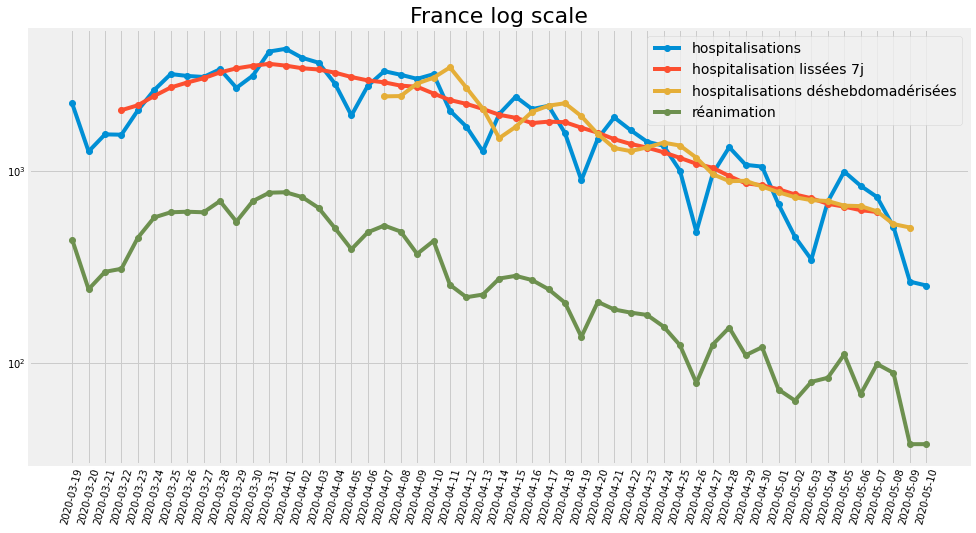


dernières données : 

            incid_hosp  incid_rea  hosp_desaiso
2020-05-06       833.0       69.0         653.0
2020-05-07       728.0       99.0         614.0
2020-05-08       510.0       89.0         527.0
2020-05-09       265.0       38.0         506.0
2020-05-10       253.0       38.0           NaN


In [5]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France log scale", logscale=True)


In [0]:
def display_dept(d_number, d_name):
    dept = df[df.dep==d_number]
    dept.set_index(dept.jour, inplace=True)

    daily = dept[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if dept["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "réanimation"]

    plt.figure(figsize=(15,8))
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(d_name, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données lissées 7j: \n")
    print(dept.rolling(7).mean().apply(np.rint).tail())
    

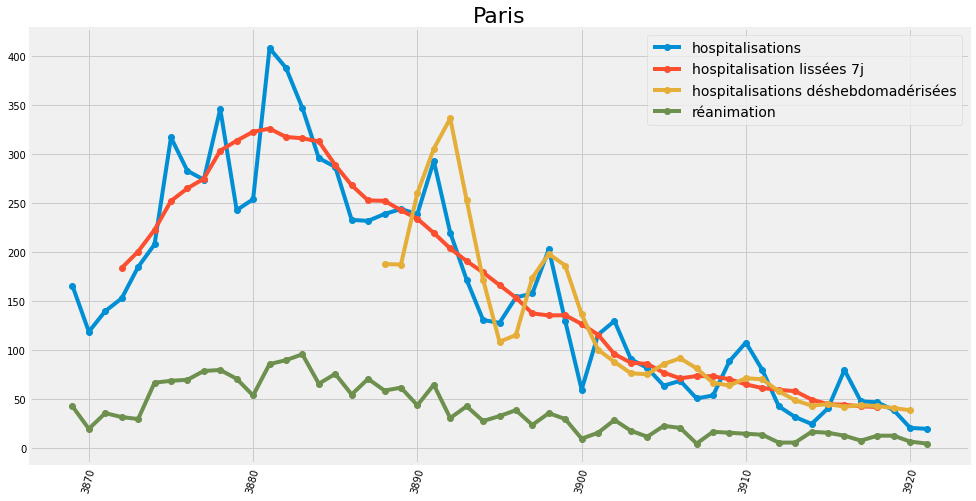


dernières données : 

      incid_hosp  incid_rea  hosp_desaiso
3917        48.0        8.0          44.0
3918        47.0       13.0          43.0
3919        39.0       13.0          41.0
3920        21.0        7.0          39.0
3921        20.0        5.0           NaN


In [7]:
display_df(df[df.dep=="75"], "Paris")

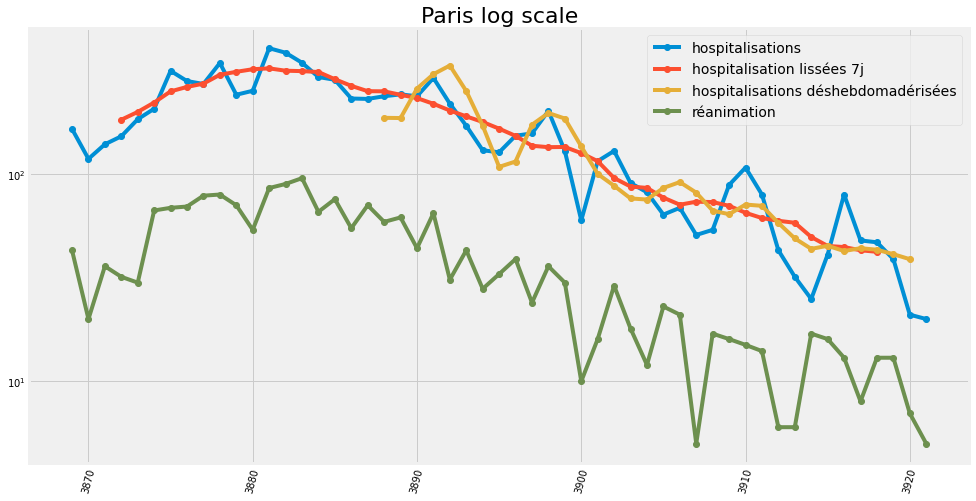


dernières données : 

      incid_hosp  incid_rea  hosp_desaiso
3917        48.0        8.0          44.0
3918        47.0       13.0          43.0
3919        39.0       13.0          41.0
3920        21.0        7.0          39.0
3921        20.0        5.0           NaN


In [8]:
display_df(df[df.dep=="75"], "Paris log scale", True)

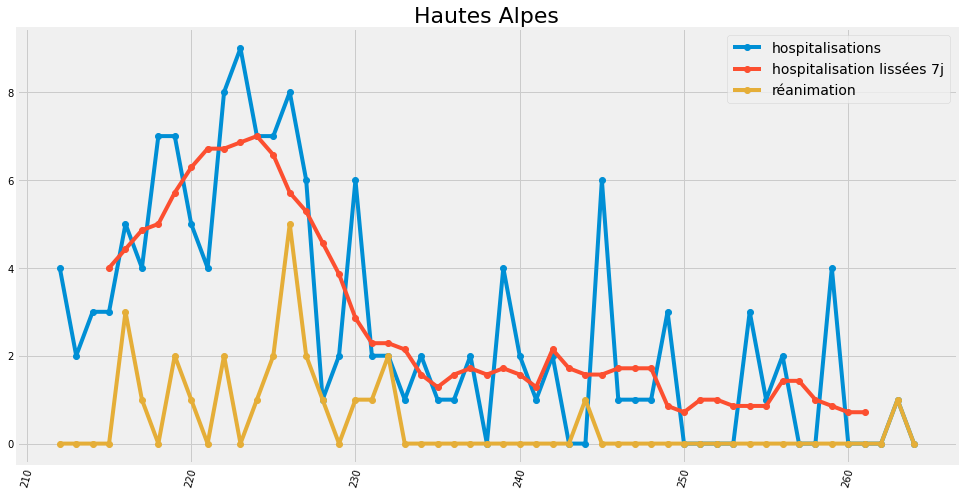


dernières données : 

     incid_hosp  incid_rea  hosp_lisse
260         0.0        0.0         1.0
261         0.0        0.0         1.0
262         0.0        0.0         NaN
263         1.0        1.0         NaN
264         0.0        0.0         NaN


In [9]:
display_df(df[df.dep=="05"],"Hautes Alpes")

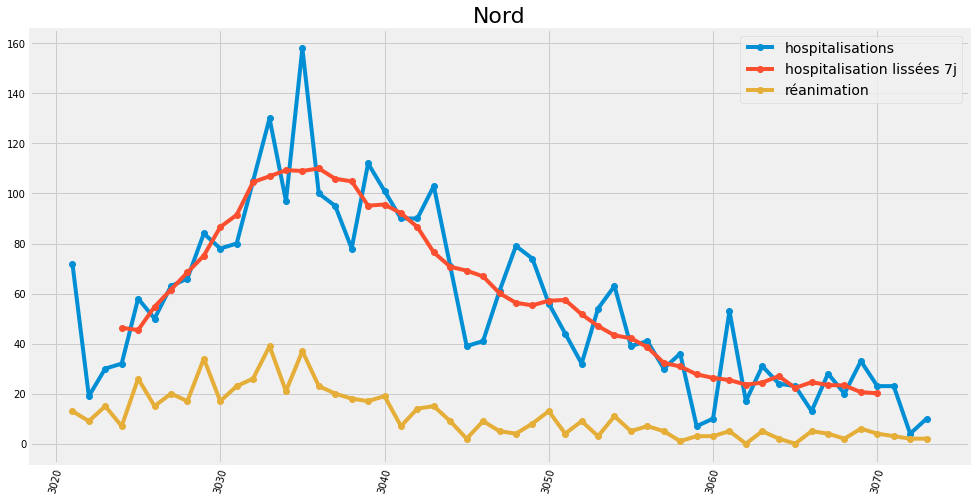


dernières données : 

      incid_hosp  incid_rea  hosp_lisse
3069        33.0        6.0        21.0
3070        23.0        4.0        20.0
3071        23.0        3.0         NaN
3072         4.0        2.0         NaN
3073        10.0        2.0         NaN


In [10]:
display_df(df[df.dep=="59"],"Nord")

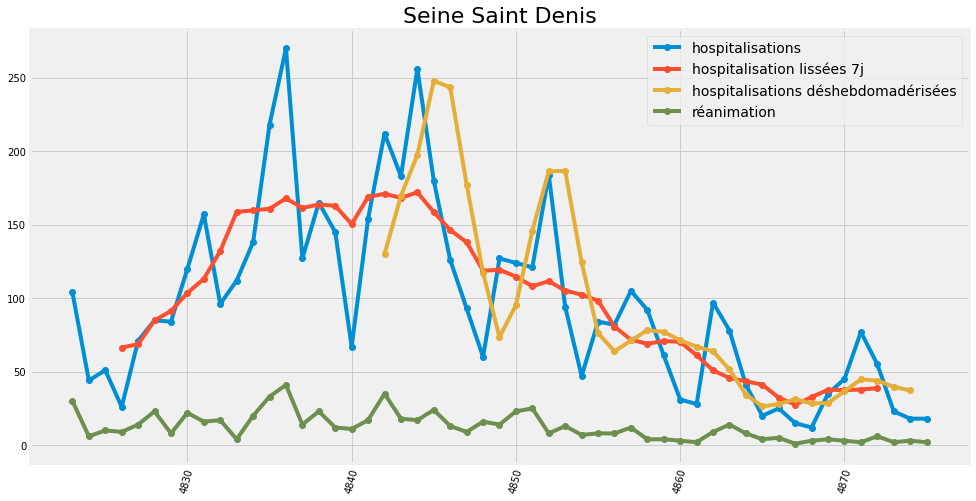


dernières données : 

      incid_hosp  incid_rea  hosp_desaiso
4871        77.0        2.0          45.0
4872        55.0        6.0          44.0
4873        23.0        2.0          40.0
4874        18.0        3.0          37.0
4875        18.0        2.0           NaN


In [11]:
display_df(df[df.dep=="93"],"Seine Saint Denis")

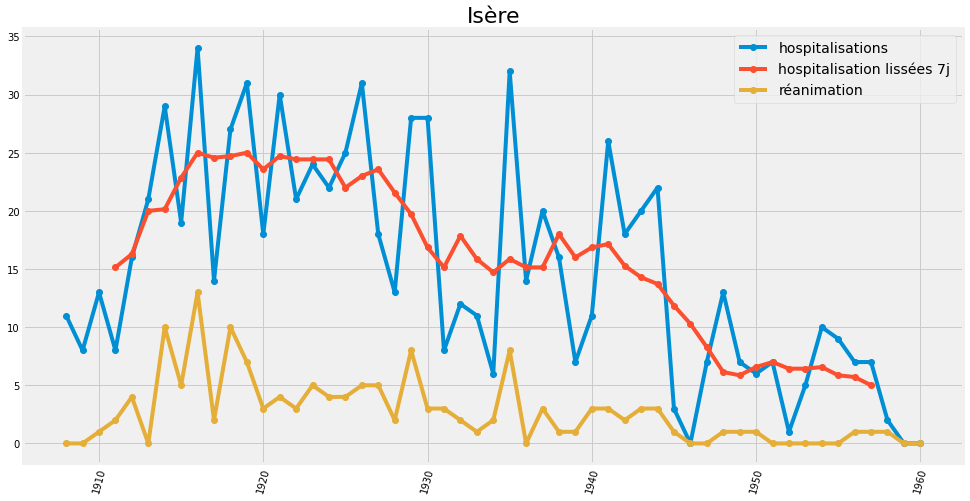


dernières données : 

      incid_hosp  incid_rea  hosp_lisse
1956         7.0        1.0         6.0
1957         7.0        1.0         5.0
1958         2.0        1.0         NaN
1959         0.0        0.0         NaN
1960         0.0        0.0         NaN


In [12]:
display_df(df[df.dep=="38"],"Isère")